In [1]:
import numpy as np
import random
import os

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def norm_x(x):
    for col in range(x.shape[1]):
        vals = x[:,col]
        vals = (vals-np.mean(vals))/np.std(vals)
        x[:,col] = vals
    return x

In [4]:
def sampleChania(Chania, n_points):
    data = Chania[:,0:8]
    order = np.argsort(np.random.random(data.shape[0]))
    x = data[order][:n_points, 1:5]   
    trueusers = data[order][:n_points,0]
    n_clusters = 5
    x = norm_x(x)
    return tf.constant(x, dtype=tf.float32), tf.constant(trueusers, dtype=tf.float32)

In [5]:
def plot_rssi(x, y, sess):
    xarray = x.eval(session=sess)
    yarray = y.eval(session=sess)
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    
    ax[0].scatter(xarray[:,3], xarray[:,2], c=xarray[:,1])
    ax[0].set_title("True Received Signal Strengths, min=%.4f, max=%.4f"%(np.min(xarray[:,1]), np.max(xarray[:,1])))
    
    ax[1].scatter(yarray[:,3], yarray[:,2], c=yarray[:,1])
    ax[1].set_title("Obfuscated Received Signal Strengths, min=%.4f, max=%.4f"%(np.min(yarray[:,1]), np.max(yarray[:,1])))

In [6]:
def plot_users(x, y, z, trueusers, sess):
    xarray = x.eval(session=sess)
    yarray = y.eval(session=sess)
    zarray = z.eval(session=sess)
    u = trueusers.eval(session=sess)
    
    fig, ax1 = plt.subplots(1, 2, figsize=(15,5))
    
    ax1[0].scatter(xarray[:,3], xarray[:,2], c=u)
    ax1[0].set_title("User Labels")
    
    ax1[1].scatter(yarray[:,3], yarray[:,2], c=u)
    ax1[1].set_title("Obfuscated data - User Labels")
    
    fig, ax2 = plt.subplots(1, 2, figsize=(15,5))
    
    ax2[0].scatter(xarray[:,3], xarray[:,2], c=np.argmax(zarray, axis=1))
    ax2[0].set_title("User Labels estimated by adversary")
    
    ax2[1].scatter(yarray[:,3], yarray[:,2], c=np.argmax(zarray, axis=1))
    ax2[1].set_title("Obfuscated data - User Labels estimated by adversary")

In [7]:
def plot_maps(sess):   
    testpoints = np.mgrid[-1.5:1.5:15j, -1.5:1.5:15j].reshape(2,-1).T
    grid = tf.constant(testpoints, dtype=tf.float32)

    inputmap = i4(i3(i2(i1(grid)))).eval(session=sess)
    outputmap = o4(o3(o2(o1(grid)))).eval(session=sess)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].scatter(testpoints[:,1], testpoints[:,0], c=inputmap[:,0])
    ax[0].set_title("Map created from True Data, min=%.4f, max=%.4f"%(np.min(inputmap[:,0]), np.max(inputmap[:,0])))
    ax[1].scatter(testpoints[:,1], testpoints[:,0], c=outputmap[:,0])
    ax[1].set_title("Map created from Obfuscated Data, min=%.4f, max=%.4f"%(np.min(outputmap[:,0]), np.max(outputmap[:,0])))

In [9]:
Chania = np.genfromtxt('processedChania.csv', delimiter=',')

In [10]:
Chania = Chania[np.where(Chania[:,2]<99)]

Restart here

In [1629]:
strategy = "GAP"

In [1630]:
sess = tf.Session()
keras.backend.set_session(sess)

In [1631]:
x, trueusers = sampleChania(Chania, 100)

In [1707]:
if strategy == "GAP":

    init = keras.initializers.Identity(gain=1.0)
#     bias_init = keras.initializers.RandomUniform(minval=-1.0, maxval=1.0, seed=None)
    p1 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
    p2 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
    p3 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
    p4 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
    p5 = keras.layers.Dense(4, kernel_initializer=init)

    y = p5(p4(p3(p2(p1(x)))))
    p_vars = [p1.variables, p2.variables, p3.variables, p4.variables, p5.variables]

In [1708]:
if strategy == "simple":
    yarray = x.eval(session=sess) + np.random.normal(scale=0.01, size=(100,4))
    y = tf.constant(yarray, tf.float32)

In [1709]:
i1 = keras.layers.Dense(4, activation=tf.nn.relu)
i2 = keras.layers.Dense(4, activation=tf.nn.relu)
i3 = keras.layers.Dense(4, activation=tf.nn.relu)
i4 = keras.layers.Dense(1)

m1 = i4(i3(i2(i1(x[:,2:]))))
m1_target = tf.keras.backend.reshape(x[:,1], (100,1))
m1_train = tf.train.GradientDescentOptimizer(0.1)
m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables]

In [1710]:
o1 = keras.layers.Dense(4, activation=tf.nn.relu)
o2 = keras.layers.Dense(4, activation=tf.nn.relu)
o3 = keras.layers.Dense(4, activation=tf.nn.relu)
o4 = keras.layers.Dense(1)

m2 = o4(o3(o2(o1(y[:,2:]))))
m2_target = tf.keras.backend.reshape(y[:,1], (100,1))
m2_train = tf.train.GradientDescentOptimizer(0.1)
m2_vars = [o1.variables, o2.variables, o3.variables, o4.variables]

In [1711]:
a1 = keras.layers.Dense(7, activation=tf.nn.relu)
a2 = keras.layers.Dense(5, activation=tf.nn.softmax)

users = a2(a1(y))
a_train = tf.train.GradientDescentOptimizer(0.08)
a_vars = [a1.variables, a2.variables]

In [1637]:
if strategy == "GAP":
    combined = a2(a1(p5(p4(p3(p2(p1(x)))))))
    combined = a2(a1(p1(x)))
    p_train = tf.train.GradientDescentOptimizer(0.1) # TODO

In [1638]:
m1_loss = tf.placeholder(tf.float32)
m2_loss = tf.placeholder(tf.float32)
map_error = tf.placeholder(tf.float32)
adversary_loss = tf.placeholder(tf.float32)
privatizer_loss = tf.placeholder(tf.float32)
penalty = tf.placeholder(tf.float32)
threshold = tf.placeholder(tf.float32)
testpoints = tf.placeholder(tf.float32)
grid = tf.placeholder(tf.float32)

In [1639]:
sess.run(tf.global_variables_initializer())

In [1640]:
m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m1, m1_target))
m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)

In [1641]:
m2_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m2, m2_target))
m2_train = m2_train.minimize(m2_loss, var_list = m2_vars)

In [1642]:
adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
a_train = a_train.minimize(adversary_loss, var_list = a_vars)

In [1643]:
# map_error = tf.reduce_mean(tf.squared_difference(
#     i4(i3(i2(i1(p5(p4(p3(p2(p1(x)))))[:,2:])))), 
#     p5(p4(p3(p2(p1(x)))))[:,1]
# ))
# map_error = tf.reduce_mean(tf.squared_difference(
#     i4(i3(i2(i1(p1(x)[:,2:])))), 
#     p1(x)[:,1]
# ))

testpoints = np.mgrid[-1.5:1.5:15j, -1.5:1.5:15j].reshape(2,-1).T
grid = tf.constant(testpoints, dtype=tf.float32)
map_error = tf.reduce_mean(tf.squared_difference(
i4(i3(i2(i1(grid)))),
o4(o3(o2(o1(grid))))))

In [1644]:
penalty = tf.constant(1, dtype=tf.float32)
threshold = tf.constant(0, dtype=tf.float32)

In [1645]:
zero = tf.constant(0, dtype=tf.float32)
privatizer_loss = tf.subtract(tf.multiply(penalty, tf.math.maximum(zero, tf.subtract(map_error, threshold))), 
                              tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, combined)))

if strategy == "GAP":
    p_train = p_train.minimize(privatizer_loss, var_list = p_vars)

In [1646]:
# m1_train.run(session=sess)
# m2_train.run(session=sess)

In [1647]:
# a_train.run(session=sess)

In [1648]:
# p_train.run(session=sess)

In [1649]:
# def train(trainstep, trainloss, max_iter, session):
#     plotlist = []
#     delta1 = 100
#     delta2 = 0
#     count_iter = 0
#     while abs(delta1 - delta2) >= 0.0001 and count_iter < max_iter:
#         count_iter += 1
#         delta1 = trainloss.eval(session=session)
#         trainstep.run(session=session)
#         delta2 = trainloss.eval(session=session)
#         plotlist.append(trainloss.eval(session=session))
#     return plotlist

In [1650]:
# macro_loss = []
# privacy = []
# utility = []

# delta1 = 1
# delta2 = 0
# count_iter = 0
# max_iter = 200

# while abs(delta1 - delta2) >= 0.001 and count_iter < max_iter:

#     x, trueusers = sampleChania(Chania, 100)
# #     y = p5(p4(p3(p2(p1(x)))))
#     y = p1(x)
#     m1 = i4(i3(i2(i1(x[:,2:]))))
#     m1_target = tf.keras.backend.reshape(x[:,1], (100,1))
#     users = a2(a1(y))
# #     combined = a2(a1(p5(p4(p3(p2(p1(x)))))))
#     combined = a2(a1(p1(x)))
    
#     delta1 = privatizer_loss.eval(session=sess)
#     m1plot = train(m1_train, m1_loss, 1000, sess)
#     aplot = train(a_train, adversary_loss, 1000, sess)
#     pplot = train(p_train, privatizer_loss, 1, sess)
#     delta2 = privatizer_loss.eval(session=sess)

#     if count_iter%10 == 0:
#         fig, ax = plt.subplots(1, 2, figsize=(15, 5))
#         fig.subplots_adjust(hspace=0.3)
#         ax[0].plot(m1plot)
#         ax[0].set_title("Loss training Map")
#         ax[1].plot(aplot)
#         ax[1].set_title("Loss training Adversary")
#         fig.suptitle("Iteration %d"%(count_iter))

#         print(count_iter)
#         print("Map error:", map_error.eval(session=sess))
#         print("Adversary error:", adversary_loss.eval(session=sess))
#         print("Privatizer loss:", privatizer_loss.eval(session=sess))
    
#     privacy.append(adversary_loss.eval(session=sess))
#     utility.append(1-map_error.eval(session=sess))
#     macro_loss.extend(pplot)
    
#     count_iter += 1

# print("Final Map error:", map_error.eval(session=sess))
# print("Final Adversary error:", adversary_loss.eval(session=sess))
# print("Final Privatizer loss:", privatizer_loss.eval(session=sess))

# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# ax[0].plot(privacy, utility)
# ax[0].set_title("Privacy Utility Curve")
# ax[1].plot(macro_loss)
# ax[1].set_title("Privatizer loss")

Text(0.5, 1.0, 'Obfuscated Received Signal Strengths')

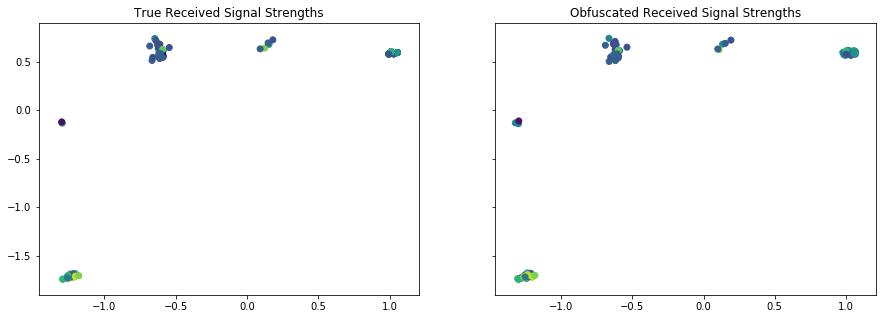

In [1651]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)

ax[0].scatter(x.eval(session=sess)[:,3], x.eval(session=sess)[:,2], c=x.eval(session=sess)[:,1])
ax[0].set_title("True Received Signal Strengths")

ax[1].scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], c=y.eval(session=sess)[:,1])
ax[1].set_title("Obfuscated Received Signal Strengths")

In [1652]:
x.eval(session=sess)[0:10]

array([[ 0.99190474,  0.22645843,  0.67808425,  0.15438268],
       [ 1.5964465 , -0.7475563 , -1.7213248 , -1.2144425 ],
       [ 0.72947305,  0.7134658 ,  0.5784655 ,  0.9947684 ],
       [ 0.02314284,  2.6614952 , -1.7136421 , -1.2033855 ],
       [-0.29397717,  1.6874806 ,  0.6401628 ,  0.12297077],
       [ 0.53059536, -0.01704526,  0.73893577, -0.6469834 ],
       [ 0.09608166, -0.26054895,  0.6024372 ,  1.01046   ],
       [-0.32624847, -0.99106   ,  0.55306745, -0.6226698 ],
       [-1.5131136 , -0.7475563 ,  0.63154835,  0.09233645],
       [-0.8016418 ,  0.46996212,  0.5784655 ,  0.9947684 ]],
      dtype=float32)

In [1653]:
y.eval(session=sess)[0:10]

array([[ 0.9888147 ,  0.22252247,  0.6803766 ,  0.13361208],
       [ 1.6018791 , -0.7467034 , -1.7114513 , -1.2248166 ],
       [ 0.73600185,  0.7062449 ,  0.5790555 ,  0.99466455],
       [ 0.02843552,  2.6640875 , -1.7189683 , -1.2127358 ],
       [-0.29806697,  1.6767927 ,  0.62334615,  0.10869025],
       [ 0.5362973 , -0.0345151 ,  0.7408527 , -0.6635777 ],
       [ 0.09516494, -0.25100762,  0.596304  ,  1.0127482 ],
       [-0.33060685, -1.0017767 ,  0.548514  , -0.61815006],
       [-1.5033209 , -0.7465794 ,  0.6305479 ,  0.09989138],
       [-0.8014417 ,  0.48169795,  0.5952534 ,  0.9769391 ]],
      dtype=float32)

In [1680]:
plotm1 = train(m1_train, m1_loss, 1000, sess)

In [1681]:
plotm2 = train(m2_train, m2_loss, 1000, sess)

In [1682]:
map_error.eval(session=sess)

0.3255718

In [1657]:
plota = train(a_train, adversary_loss, 10000, sess)

In [1658]:
adversary_loss.eval(session=sess)

0.058849882

Text(0.5, 1.0, 'True Labels (Obfuscated)')

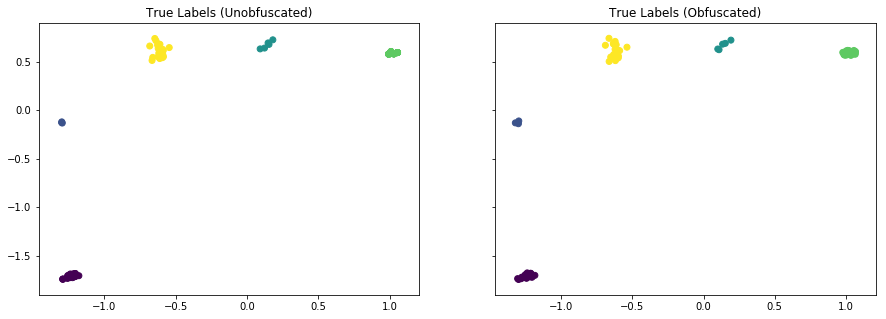

In [1659]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)

ax[0].scatter(x.eval(session=sess)[:,3], x.eval(session=sess)[:,2], c=trueusers.eval(session=sess))
ax[0].set_title("True Labels (Unobfuscated)")

ax[1].scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], c=trueusers.eval(session=sess))
ax[1].set_title("True Labels (Obfuscated)")

Text(0.5, 1.0, 'Predicted Labels (Obfuscated)')

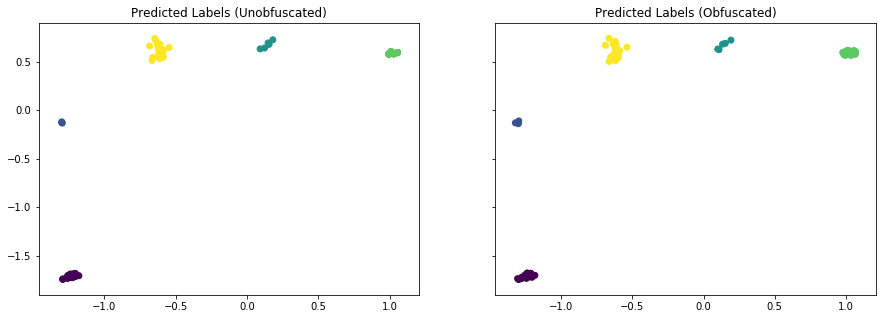

In [1660]:
fig, ax = plt.subplots(1, 2, figsize=(15,5), sharex=True, sharey=True)

ax[0].scatter(x.eval(session=sess)[:,3], x.eval(session=sess)[:,2], c=np.argmax(a2(a1(x)).eval(session=sess), axis=1))
ax[0].set_title("Predicted Labels (Unobfuscated)")

ax[1].scatter(y.eval(session=sess)[:,3], y.eval(session=sess)[:,2], c=np.argmax(a2(a1(y)).eval(session=sess), axis=1))
ax[1].set_title("Predicted Labels (Obfuscated)")

Text(0.5, 1.0, 'Map created from Obfuscated Data')

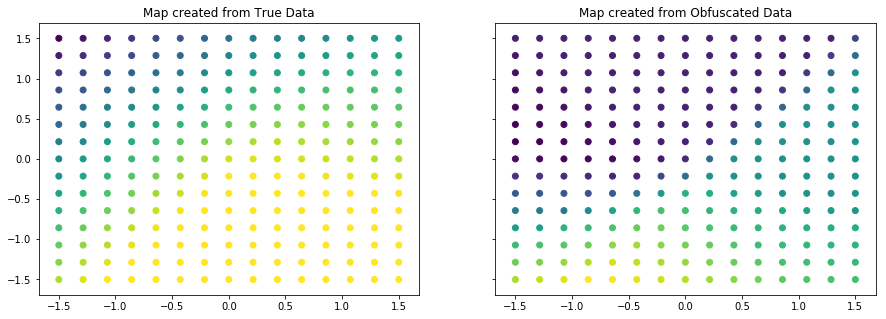

In [1661]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

inputmap = i4(i3(i2(i1(grid)))).eval(session=sess)
outputmap = o4(o3(o2(o1(grid)))).eval(session=sess)

ax[0].scatter(testpoints[:,1], testpoints[:,0], c=inputmap[:,0])
ax[0].set_title("Map created from True Data")

ax[1].scatter(testpoints[:,1], testpoints[:,0], c=outputmap[:,0])
ax[1].set_title("Map created from Obfuscated Data")

# Privacy Utility plot

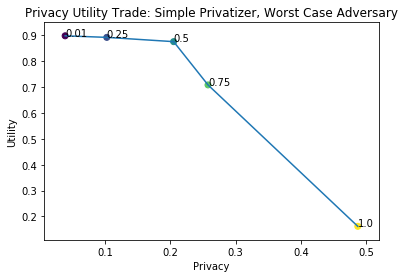

In [1706]:
if strategy == "simple":

    noise = [1.0, 0.75, 0.5, 0.25, 0.01]
    privacy = [0.48690057,0.25764972,0.20504357,0.10274291,0.038995653]
    utility = [1-x for x in [0.8381684,0.29147318,0.12419731,0.1076917,0.101653114]]

    plt.scatter(privacy, utility, c=noise)
    plt.plot(privacy, utility)
    plt.xlabel("Privacy")
    plt.ylabel("Utility")
    plt.title("Privacy Utility Trade: Simple Privatizer, Worst Case Adversary")
    for i in range(len(noise)):
        plt.text(privacy[i], utility[i], str(noise[i]))

# TEST SECTION

### Adversary in isolation

one relu layer with 7 units, one softmax layer with 5 outputs  
learning rate 0.08, stop early at delta = 0.0001

In [50]:
np.random.seed(0)

sess = tf.Session()
keras.backend.set_session(sess)
x, trueusers = sampleChania(Chania, 100)

a1 = keras.layers.Dense(7, activation=tf.nn.relu)
a5 = keras.layers.Dense(5, activation=tf.nn.softmax)

users = a5(a1(x))
a_vars = [a1.variables, a5.variables]


a_train = tf.train.GradientDescentOptimizer(0.08)
sess.run(tf.global_variables_initializer())

adversary_loss = tf.reduce_mean(tf.keras.backend.sparse_categorical_crossentropy(trueusers, users))
a_train = a_train.minimize(adversary_loss, var_list = a_vars)

after 826 iterations...
final loss 0.04096859


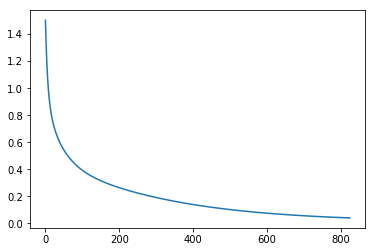

In [51]:
train(a_train, adversary_loss, 1000, True)

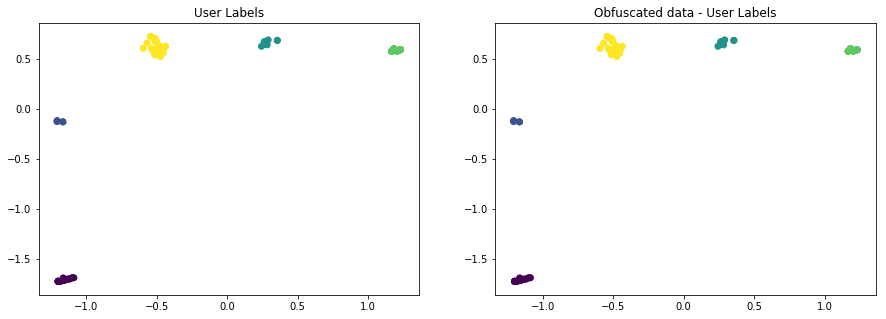

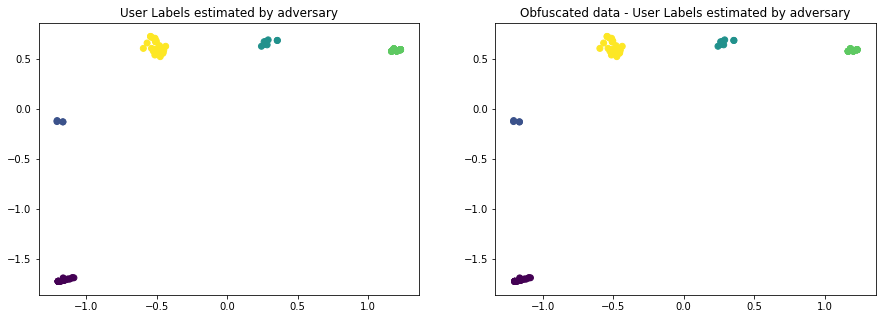

In [52]:
plot_users(x, x, users, trueusers, sess)

### Map in isolation

In [44]:
np.random.seed(0)

sess = tf.Session()
keras.backend.set_session(sess)

x, trueusers = sampleChania(Chania, 80)

i1 = keras.layers.Dense(4, activation=tf.nn.relu)
i2 = keras.layers.Dense(4, activation=tf.nn.relu)
i3 = keras.layers.Dense(4, activation=tf.nn.relu)
# i4 = keras.layers.Dense(16, activation=tf.nn.relu)
# i5 = keras.layers.Dense(16, activation=tf.nn.relu)
# i6 = keras.layers.Dense(16, activation=tf.nn.relu)
# i7 = keras.layers.Dense(16, activation=tf.nn.relu)
i8 = keras.layers.Dense(1)

# m1 = i8(i7(i6(i5(i4(i3(i2(i1(x[:,2:]))))))))
m1 = i8(i3(i2(i1(x[:,2:]))))
# m1_vars = [i1.variables, i2.variables, i3.variables, i4.variables, 
#            i5.variables, i6.variables, i7.variables, i8.variables]
m1_vars = [i1.variables, i2.variables, i3.variables, i8.variables]

m1_target = tf.keras.backend.reshape(x[:,1], (80,1))
m1_train = tf.train.GradientDescentOptimizer(0.1)
m1_loss = tf.placeholder(tf.float32)

sess.run(tf.global_variables_initializer())

m1_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(m1, m1_target))
m1_train = m1_train.minimize(m1_loss, var_list = m1_vars)

after 41 iterations...
final loss 0.6482523


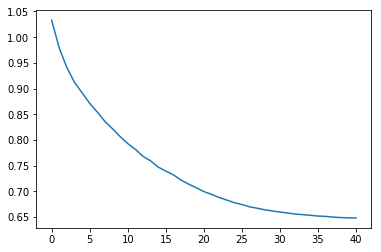

In [45]:
train(m1_train, m1_loss, 100, True)

Text(0.5, 1.0, 'True Received Signal Strengths, min=-3.0709, max=2.5768')

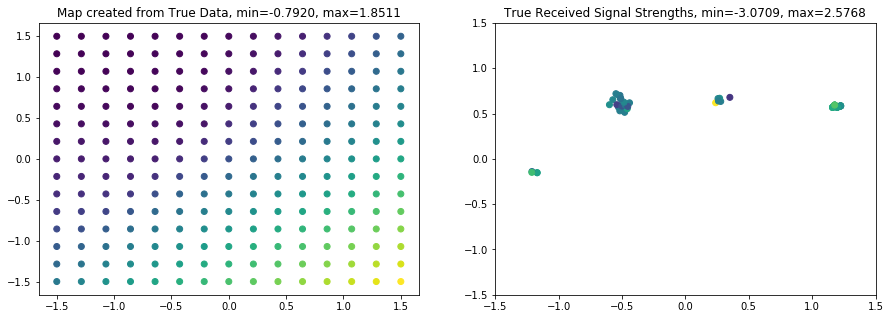

In [46]:
testpoints = np.mgrid[-1.5:1.5:15j, -1.5:1.5:15j].reshape(2,-1).T
grid = tf.constant(testpoints, dtype=tf.float32)

inputmap = i8(i3(i2(i1(grid)))).eval(session=sess)
xarray = x.eval(session=sess)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].scatter(testpoints[:,1], testpoints[:,0], c=inputmap[:,0])
ax[0].set_title("Map created from True Data, min=%.4f, max=%.4f"%(np.min(inputmap[:,0]), np.max(inputmap[:,0])))
    
ax[1].scatter(xarray[:,3], xarray[:,2], c=xarray[:,1])
ax[1].set_xlim([-1.5,1.5])
ax[1].set_ylim([-1.5,1.5])
ax[1].set_title("True Received Signal Strengths, min=%.4f, max=%.4f"%(np.min(xarray[:,1]), np.max(xarray[:,1])))

### Privatizer in Isolation

In [842]:
_sess = tf.Session()
keras.backend.set_session(_sess)

In [843]:
_x, _trueusers = sampleChania(Chania, 5)

In [844]:
init = keras.initializers.Identity(gain=1.0)

_p1 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu) # TODO
_p2 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
_p3 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
_p4 = keras.layers.Dense(4, kernel_initializer=init, activation=tf.nn.relu)
_p5 = keras.layers.Dense(4)

_y = _p5(_p4(_p3(_p2(_p1(_x)))))
_p_vars = [_p1.variables, _p2.variables, _p3.variables, _p4.variables, _p5.variables]

In [845]:
_p_train = tf.train.GradientDescentOptimizer(0.5) # TODO

In [846]:
_privatizer_loss = tf.placeholder(tf.float32)

In [847]:
_sess.run(tf.global_variables_initializer())

In [848]:
_privatizer_loss = tf.reduce_mean(tf.keras.losses.mean_squared_error(_x, _y))
_p_train = _p_train.minimize(_privatizer_loss, var_list = _p_vars)

In [855]:
train(_p_train, _privatizer_loss, 100, sess=_sess)

[0.31329244,
 0.23783453,
 0.19674805,
 0.17871472,
 0.62472284,
 0.67775524,
 0.58706343,
 0.40465078,
 0.23360972,
 0.22467391,
 0.16576698,
 0.20148757,
 0.14356022,
 0.16138431,
 0.14612587,
 0.1638451,
 0.15310262,
 0.16192342,
 0.16185935]

In [856]:
_xarray = _x.eval(session=_sess)

In [857]:
_yarray = _y.eval(session=_sess)

In [858]:
msearray = tf.keras.losses.mean_squared_error(_x, _y).eval(session=_sess)

In [859]:
_xarray

array([[-1.1854978 , -0.5647102 ,  0.8125062 ,  0.80874366],
       [ 1.1371523 , -0.8784381 , -1.2460182 , -1.2477574 ],
       [-1.2188804 ,  1.945113  , -1.2032249 , -1.2013831 ],
       [ 0.7138603 , -0.2509823 ,  0.8125062 ,  0.80874366],
       [ 0.5533656 , -0.2509823 ,  0.82423055,  0.8316533 ]],
      dtype=float32)

In [860]:
_yarray

array([[-0.09422031, -0.29039252,  0.40690666,  0.34964973],
       [ 1.1848148 , -0.83729184, -1.253633  , -1.2584431 ],
       [-1.4274968 ,  2.3702123 , -1.4054091 , -1.4061847 ],
       [-0.04335663, -0.30432403,  0.5448174 ,  0.48736328],
       [-0.0386709 , -0.30495685,  0.5528917 ,  0.50550616]],
      dtype=float32)

In [865]:
tf.reduce_mean(tf.squared_difference(_xarray, _yarray)).eval(session=_sess)

0.16185935